<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
print(tf.config.list_physical_devices('CPU'))
print(tf.config.list_logical_devices('GPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


##Download Dataset

In [26]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True)


In [27]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


(-0.5, 499.5, 332.5, -0.5)

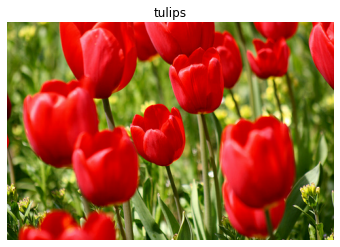

In [28]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
plt.imshow(image.numpy().astype('uint8'))
plt.title(get_label_name(label))
plt.axis('off')

###Resizing and Rescaling

In [29]:
from tensorflow.keras.models import Sequential

IMG_SIZE = 180
resizing_and_rescaling = Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])


(-0.5, 179.5, 179.5, -0.5)

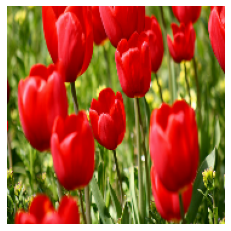

In [30]:
result = resizing_and_rescaling(image)
plt.imshow(result)
plt.axis('off')

In [31]:
print("Min: {} and Max: {} values of result.".format(result.numpy().min(), result.numpy().max()))

Min: 0.0 and Max: 1.0 values of result.


##Data Augmentation

In [32]:
data_augmentation = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [33]:
print(image.shape)
print(result.shape)
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

(333, 500, 3)
(180, 180, 3)


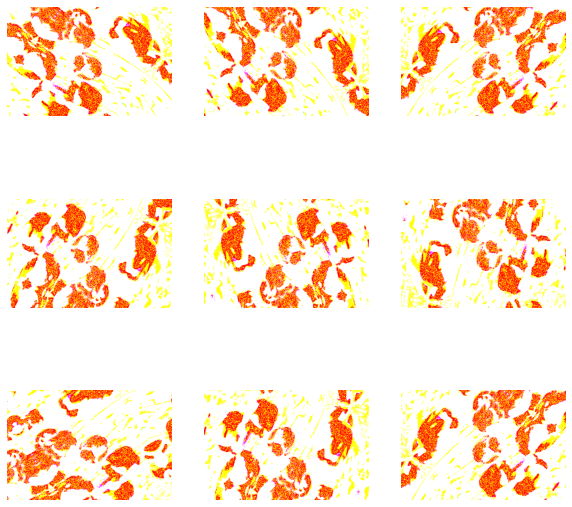

In [34]:

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0])
    plt.axis('off')
plt.show()

##Apply preprocessing layers to Dataset

In [37]:
batch_size = 32

AUTOTUNE = tf.data.AUTOTUNE

def preprocess(ds, shuffle=False, augment=False):
    """Apply keras preprocess layers to dataset."""
    ds = ds.map(lambda x, y: (resizing_and_rescaling(x), y), 
                num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(10000)
    # Batch all datasets
    ds = ds.batch(batch_size)
    # Use augmentation only on training data
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    # Use buffered prefetch on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [38]:
train_ds = preprocess(train_ds, shuffle=True, augment=True)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

##Create a model

In [42]:
model = Sequential([
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [44]:
# Train for a few epochs
epochs = 5 

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 95s 957ms/step - loss: 1.3540 - accuracy: 0.4016 - val_loss: 1.1367 - val_accuracy: 0.5259
Epoch 2/5
92/92 [==============================] - 85s 892ms/step - loss: 1.1039 - accuracy: 0.5507 - val_loss: 1.0109 - val_accuracy: 0.6349
Epoch 3/5
92/92 [==============================] - 84s 891ms/step - loss: 0.9906 - accuracy: 0.6141 - val_loss: 1.0133 - val_accuracy: 0.5913
Epoch 4/5
92/92 [==============================] - 83s 884ms/step - loss: 0.9470 - accuracy: 0.6189 - val_loss: 1.0341 - val_accuracy: 0.5940
Epoch 5/5
92/92 [==============================] - 84s 887ms/step - loss: 0.8856 - accuracy: 0.6444 - val_loss: 0.8896 - val_accuracy: 0.6431


In [45]:
loss, acc = model.evaluate(test_ds)
print("Accuracy: {:.2f}%, Loss: {:.2f}".format(acc *100, loss))

12/12 [==============================] - 3s 255ms/step - loss: 0.8133 - accuracy: 0.6594
Accuracy: 65.94%, Loss: 0.81
